<a href="https://colab.research.google.com/github/HotuRam/Bear_classifier/blob/main/my_bear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import fastai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import torch

In [23]:
from fastai.vision.all import *

In [24]:
bear_types = 'grizzly','black','teddy','pandas','polar'


In [25]:
path = Path('/content/drive/MyDrive/bears') #make sure you gave currect path

In [26]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [27]:
dls = bears.dataloaders(path)

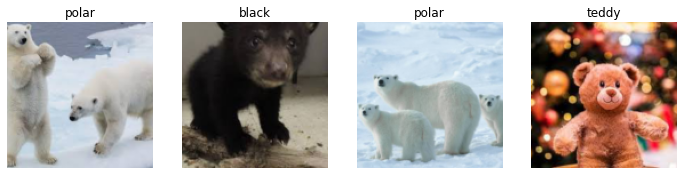

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

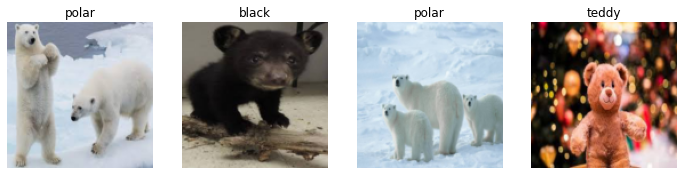

In [29]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

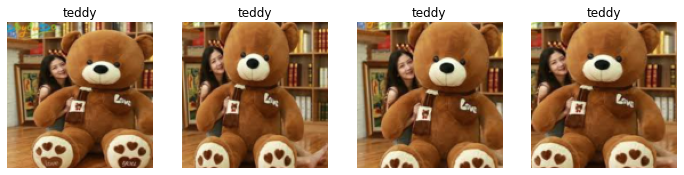

In [30]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path,bs=5)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Hi, I had the same problem, it came out because I was only testing a few images, the batch size is by default bs = 64. If you change that value for a lower one, it will work.

dls = bears.dataloaders(path,bs=5)
dls.show_batch(nrows=1, ncols=3)

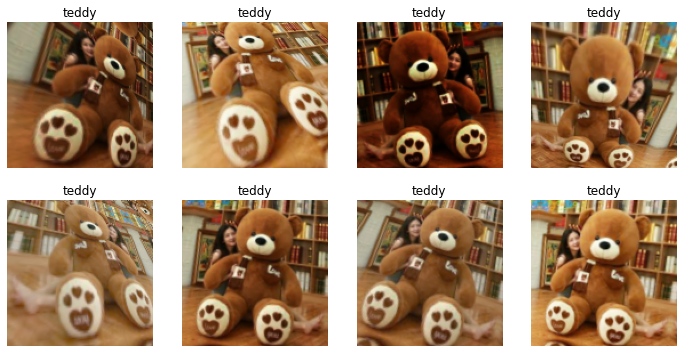

In [42]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path,bs=64)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [44]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [45]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.338536,1.977337,0.606557,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.015662,0.687018,0.229508,00:03
1,0.688264,0.137437,0.032787,00:03
2,0.509150,0.067814,0.016393,00:03
3,0.397095,0.061711,0.016393,00:03


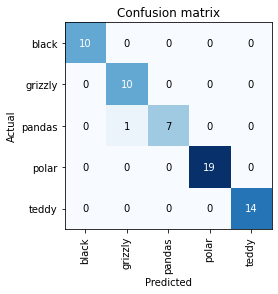

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

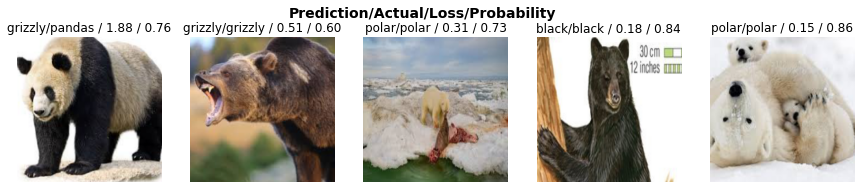

In [47]:
interp.plot_top_losses(5, nrows=1)

In [56]:
from fastai.vision.widgets import *

In [57]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [58]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [59]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [60]:
learn.export()

In [61]:
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [62]:
learn_inf = load_learner(path/'export.pkl')

In [64]:
learn_inf.predict('/content/drive/MyDrive/bears/polar/polar_bear1.jpg')

('polar',
 TensorBase(3),
 TensorBase([3.3253e-07, 2.0721e-06, 2.0527e-05, 9.9994e-01, 3.5093e-05]))

In [65]:
learn_inf.dls.vocab

['black', 'grizzly', 'pandas', 'polar', 'teddy']

## Creating a Notebook App from the Model


In [94]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [84]:
#hide
# For the book, we can't actually click an upload button, so we fake it
# btn_upload = SimpleNamespace(data = ['/content/drive/MyDrive/bears/grizzly/grizzly25.jpg'])

In [85]:
img = PILImage.create(btn_upload.data[-1])

In [86]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [87]:

pred,pred_idx,probs = learn_inf.predict(img)

In [88]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [89]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [90]:
def on_click_classify(change):
 img = PILImage.create(btn_upload.data[-1])
 out_pl.clear_output()
 with out_pl: display(img.to_thumb(128,128))
 pred,pred_idx,probs = learn_inf.predict(img)
 lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [95]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

##  Turning Your Notebook into a Real App


In [96]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 343 kB 40.3 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 111 kB 47.6 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 132 kB 51.2 MB/s 
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.2.5 requires Jinja2<3.1.0, but you have jinja2 3.1.1 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.1 wh